# Batch video analysis
#### Author: Youngbin Kim
#### Last updated: 02/21/24

Note: This notebook goes over basic batch analysis of multiple videos in a folder for contractility, calcium handling, and pillar deflection functional assessment. To analyze a single video, please check the single video analysis notebook. For a more user friendly approach, download the GUI program on our [website](https://beatprofiler.github.io).

## Workflow Outline
#### Option A: Using preset .yaml file (simple)
#### Option B: Defining configuration manually (more customized)
1. Defining resources available on the computer
2. Selecting files for analysis and defining export paths
<br>(Optional) Defining splits and excluding the beginning from analysis

3. Defining what to analyze and export
4. Read video and extract time series
5. Analyze trace to segment beats and extract function
6. Save and export Excel files
<br>(Bonus) Visualize in Jupyter Notebook

## Import packages

In [1]:
import beatprofiler as bp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import warnings

## Option A: Use the configuration file (simple)

Configuration files are generated from a previous BeatProfiler GUI run and can be opened up in a text editor for additional modifications. They are Python dictionaries containing parameters for class methods.

In [2]:
# folder containing all your videos
folder_to_analyze = "sample videos"
# export folder to save your analysis
export_path = "export"
# modify this configuration file according to your videos
yaml_file_path = "tissue.yaml"

In [3]:
batch_analyzer = bp.BatchVideoAnalyzer(folder_path = folder_to_analyze,
                                       config_file = yaml_file_path)
batch_analyzer.analyze_and_export(export_path = export_path)


0: 576x1024 2 1s, 212.4ms
Speed: 31.0ms preprocess, 212.4ms inference, 97.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 576x1024 1 t, 217.8ms
Speed: 29.0ms preprocess, 217.8ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)


<Figure size 640x480 with 0 Axes>

##### Exported files should appear in the folder defined in your "export_path" variable.

## Option B: Define your own configuration settings directly (more customized)

Instructions: Blocks starting with '### DEFINE' need to be modified with your own parameters. Other blocks remain as is unless you want to customize analysis.

### 1. Defining resources available on the computer

If you are dealing with analysis of large videos, or your computer is low on memory (RAM), set this parameter to <b>True</b>. This will load the video in chunks, which will enable analysis in resource intensive conditions while sacrificing analysis speed.

In [4]:
low_ram = False

### 2. Selecting files for analysis and defining export paths

In [5]:
### DEFINE file related parameters

# folder containing all your videos
folder_path = "sample videos"

# file extensions of your video
# all other file extensions in the folder will be ignored
file_ext = "mov"

# frame rate of each video
frame_rate = 20

# acquisition mode is None by default
# if acquisition mode is "pycromanager", it splits large video files into chunks
# the program assumes a file extension of .tif and stitches files within the same folder 
acq_mode = None

# define where to save everything
export_path = "export"

In [6]:
# recursively search thru folder to find files of given extension
file_list = glob.glob(os.path.normpath(os.path.join(folder_path, "**/*"+"."+file_ext)), recursive=True)

# for pycromanager 
if acq_mode == "pycromanager":
    file_list = np.unique(np.array([os.path.dirname(os.path.dirname(f)) for f in file_list]))

file_list

['sample videos\\bf tissue 20fps.mov']

### (Optional) Defining splits and excluding the beginning from analysis

In [7]:
### DEFINE splits, units, and skip_first_n parameters (Optional)

# When undefined, splits = [[0,None]], indicating a single split encompassing the whole video
# and skip_first_n = 0


# BeatProfiler can do split analysis for different segments of each video
# This is useful for continuous videos in which you have different external stimuli like drug exposure or electrical stimulation.
# e.g. 0-20 seconds of baseline recording, 20-30s electrical pacing at 1Hz

# splits are arrays of 2 element arrays
# the first number is the starting frame/seconds, and the second number is the end frame/seconds
# the last second number should be None to indicate that you are analyzing until the end of the video
splits = [[0, 20],
          [20, None]
         ]

# split units are either 'seconds' or frames'
split_units = 'seconds'

# skip_first_n is used to skip the first n 'seconds' or frames' from analysis
# this is used when you want to exclude the beginning of each split
# to let your cardiomyocytes acclimate to the new drug/electrical pacing
skip_first_n = 0

In [8]:
# convert splits into units of frames (split_units are either in 'seconds' or 'frames')
if split_units == "seconds":
    # multiply by frame_rate if it's not None
    splits_frames = [[int(np.round(sec * frame_rate)) if sec else None for sec in split] for split in splits]
    skip_first_n_frames = int(np.round(skip_first_n * frame_rate))
else:
    splits_frames = splits
    skip_first_n_frames = skip_first_n

### 3. Defining what to analyze and export

In [9]:
### DEFINE a list of things to export

# 'labeled_video' is only for pillar deflection analysis
export_list = ['summary',
               'peak_summary',
               'traces',
               'plot_trace',
               'plot_mask',
               'labeled_video',
               'beat_segments']



In [10]:
# save locations
if "plot_mask" in export_list:
    plot_mask = True
    plot_mask_path = os.path.join(export_path, "plot_mask")
else:
    plot_mask = False
    plot_mask_path = None

if "labeled_video" in export_list:
    labeled_video = True
    labeled_video_path = os.path.join(export_path, "labeled_video")
else:
    labeled_video = False
    labeled_video_path = None

if "plot_trace" in export_list:
    plot_trace = True
    plot_trace_path = os.path.join(export_path, "plot_trace")
else:
    plot_trace = False
    plot_trace_path = None


### 4. Read video and extract time series
#### Run either 4A (Contractiliy/Calcium) or 4B (Tissue) depending on your analysis

#### 4A. Contractility and Calcium Analysis

In [47]:
### DEFINE Video parameters

# video type is either 'brightfield' (contractility) or "fluorescent" (Calcium/Voltage)
vid_type = "fluorescent"

# settings for mask calculations
video_mask_config = {
                     # sometimes masks are inverted. in that case, change this to True. Otherwise, default is False
                     'invert': False,
                     # Method for detecting the region of interest. Needs to be one of the following: None, "dynamic range", "max fft", "mean fft", "fundamental", "YOLOv8 segmentation"
                     'method': 'YOLOv8 segmentation'
}

# settings for trace calculations (only need to define for contractility modality)
video_trace_config = {
                      # reference : 'auto', 'mean', 'range', or 'manual'
                      'reference': "auto"
}

In [48]:
raw_traces = pd.DataFrame()

for i in range(len(file_list)):
    
    # Assigning name for each video
    if file_list[i] == folder_path:
        name = os.path.basename(file_list[i])
    else:
        name = os.path.splitext(file_list[i].replace(folder_path, "")[1:])[0]
    
    # calcium/voltage videos
    if vid_type == "fluorescent":
        video = bp.FluoVideo(file_path=file_list[i], acq_mode=acq_mode, frame_rate=frame_rate, name=name, low_ram=low_ram, max_bpm=360)
    
    # contractility videos
    else:
        video = bp.BFVideo(file_path=file_list[i], acq_mode=acq_mode, frame_rate=frame_rate, name=name, low_ram=low_ram, max_bpm=360)
    
    # calculate mask
    video.calculate_mask(savefig=plot_mask, savefig_path=plot_mask_path, **video_mask_config)
    
    # extract trace
    video.calculate_trace(**video_trace_config)
    
    # append trace to the dataframe
    raw_traces = pd.concat([raw_traces, pd.Series(video.trace[1:], name = name).to_frame().T])

#### 4B. Pillar Deflection Analysis (Tissue Force)

In [11]:
### DEFINE Video parameters

# video type is tissue (pillar deflection)
vid_type = "tissue"

# settings for mask calculations
video_mask_config = {
                     # sometimes masks are inverted. in that case, change this to True. Otherwise, default is False
                     'invert': False,
                     # Method for detecting the region of interest. Needs to be one of the following: None, "dynamic range", "max fft", "mean fft", "fundamental", "YOLOv8 segmentation"
                     'method': 'YOLOv8 segmentation',
                     # path to the segmentation model if method is 'YOLOv8 segmentation'
                     'yolo_seg_model': r"C:\Program Files (x86)\BeatProfiler\_internal\yolo_models\tissue seg milliPillar.pt",}

# settings for trace calculations (only need to define for contractility modality)
video_trace_config = {
                      # method for selecting object to track (str or np.array)
                      # files ending in .pt is expected to be a YOLOv8 model to detect anchor bounding box
                      # files ending in .csv is expected to contain coordinates of 2 bounding boxes in this format (x1,y1,x2,y2) for each box
                      # numpy array is expected to be in shape (2,4)
                      'bounding_box': r"C:\Users\YBLab\Documents\GitHub\BeatProfiler\yolo_models\pillar det milliPillar.pt",
                      # 'grid' for a grid like point tracking, auto' for ShiTomasi method
                      'anchor_method': 'grid',
                      # number of points for each anchor to use to track
                      'n': 25,
                      # optical flow parameter
                      'window_size': 30}

In [12]:
raw_traces = pd.DataFrame()
tissue_params = {}

for i in range(len(file_list)):
    
    # Assigning name for each video
    if file_list[i] == folder_path:
        name = os.path.basename(file_list[i])
    else:
        name = os.path.splitext(file_list[i].replace(folder_path, "")[1:])[0]
    
    # Initialize Tissue Video
    video = bp.TissueVideo(file_path=file_list[i], acq_mode=acq_mode, frame_rate=frame_rate, name=name, low_ram=low_ram, max_bpm=360)
    
    # for tissue video analysis, calculate mask and trace needs to be run first before width calculation
    video.calculate_trace(savevid=labeled_video, savevid_path=labeled_video_path, **video_trace_config)
    video.calculate_mask(savefig=plot_mask, savefig_path=plot_mask_path, **video_mask_config)
    video.calculate_width(savefig=plot_mask, savefig_path=plot_mask_path)

    # save tissue specific parameters
    if not "width_pxs" in tissue_params.keys():
        tissue_params["width_pxs"] = []
    if not "tissue_areas" in tissue_params.keys():
        tissue_params["tissue_areas"] = []
    if not "resting_dist_pxs" in tissue_params.keys():
        tissue_params["resting_dist_pxs"] = []
    tissue_params["width_pxs"].append(video.width)
    tissue_params["tissue_areas"].append(video.area)
    tissue_params["resting_dist_pxs"].append(video.resting_dist)

    # append trace to the dataframe
    raw_traces = pd.concat([raw_traces, pd.Series(video.trace[1:], name = name).to_frame().T])


0: 576x1024 2 1s, 11.5ms
Speed: 31.5ms preprocess, 11.5ms inference, 7.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 576x1024 1 t, 30.0ms
Speed: 29.8ms preprocess, 30.0ms inference, 8.0ms postprocess per image at shape (1, 3, 1024, 1024)


<Figure size 640x480 with 0 Axes>

### 5. Analyze trace to segment beats and extract function
#### Run either 5A (Contractiliy/Calcium) or 5B (Tissue) depending on your analysis

#### 5A. Contractility and Calcium Analysis

In [49]:
### DEFINE Trace Parameters

trace_drift_correction_config = {
                                 # Photobleach correction method.
                                 # None (no correction) for traces that do not need correction (such as contractility)
                                 # 'exp' (recommended) fits an exponential decay function through the valley points to calculate the baseline F0.
                                 # 'power' fits a power function that mimics an exponential decay (use if exp fails to converge).
                                 # 'linear' fits a line of best fit.
                                 # 'interpolation' interpolates between valley points in a 'connect the dot' fashion.
                                 'method': 'exp', 
    
                                 # Peak height prominence threshold for valley detection.
                                 # Higher threshold is better for noisy signals, but too low values could miss valleys.
                                 # This value will be ignored if method is None.
                                 'min_prominence': 0.1}

trace_analyze_peaks_config = {
                              # Peak height prominence threshold for beat detection.
                              # Higher threshold is better for noisy signals, but too low values could miss beats.
                              'min_prominence': 0.2}

In [51]:
# Extracting traces from videos

os.makedirs(export_path, exist_ok=True)


total_summary_splits = []
peak_summary_splits = []
raw_data_splits = []
df_f0_splits = []
velocity_splits = []
segments_splits = []



for split_i in range(len(splits)):
    split = splits[split_i]
    
    total_summary = pd.DataFrame()
    peak_summary = pd.DataFrame()
    df_f0 = pd.DataFrame()
    velocity = pd.DataFrame()
    segments = pd.DataFrame()
    raw_data = pd.DataFrame()

    for i in range(len(raw_traces)):
        # batch analysis of videos of different sizes results in nan values at the end
        data_numpy = raw_traces.iloc[i, splits_frames[split_i][0]:splits_frames[split_i][1]].to_numpy()
        data_numpy = data_numpy[~np.isnan(data_numpy)]
        
        # Excel sheets are named based on split number
        if len(splits) == 1:
            name = raw_traces.index[i]
        else:
            name = raw_traces.index[i] + " split " + str(split_i+1)

        # suppress warnings: warnings are thrown when baseline fit doesnt converge well or if the number of peaks is < 3
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # this variable doesnt exist if the optional block wasn't run above
            if not 'skip_first_n_frames' in locals():
                skip_first_n_frames = 0
            
            # traces 
            trace = bp.Trace(data=data_numpy,frame_rate=frame_rate, max_bpm=360, skip_first_n_frames=skip_first_n_frames, name=name)
            trace.calculate_drift(**trace_drift_correction_config)
            trace.analyze_peaks(savefig=plot_trace, savefig_path=plot_trace_path, **trace_analyze_peaks_config)
        
        # append all data extracted from this trace to the full dataframe
        total_summary = pd.concat([total_summary,trace.feature_summary.to_frame().T])
        peak_summary = pd.concat([peak_summary, trace.peak_summary])
        df_f0 = pd.concat([df_f0, pd.Series(trace.df_f0, name=name).to_frame().T])
        velocity = pd.concat([velocity, pd.Series(trace.velocity, name=name).to_frame().T])
        segments = pd.concat([segments, trace.beat_segments])
        raw_data = pd.concat([raw_data, pd.Series(trace.raw_data, name=name).to_frame().T])

    # drop empty columns (i.e. velocity with vs without units, df/f0 amplitude, etc)
    total_summary = total_summary.dropna(how="all", axis=1)
    peak_summary = peak_summary.dropna(how="all", axis=1)

    total_summary_splits.append(total_summary)
    peak_summary_splits.append(peak_summary)

    # relabel the columns in units of seconds
    timestamp = np.linspace(start=0, stop=df_f0.shape[1]/frame_rate, num=df_f0.shape[1])
    df_f0 = df_f0.rename(columns=dict(zip(df_f0.columns, timestamp)))
    velocity = velocity.rename(columns=dict(zip(velocity.columns, timestamp)))
    raw_data = raw_data.rename(columns=dict(zip(raw_data.columns, timestamp)))

    seg_timestamp = np.linspace(start=0, stop=segments.shape[1]/frame_rate, num=segments.shape[1])
    segments = segments.rename(columns=dict(zip(segments.columns, seg_timestamp)))

    df_f0_splits.append(df_f0)
    velocity_splits.append(velocity)
    raw_data_splits.append(raw_data)
    segments_splits.append(segments)

<Figure size 640x480 with 0 Axes>

#### 5B. Pillar Deflection Analysis (Tissue Force)

In [13]:
### DEFINE Trace Parameters

tissue_init_config = {
                      # Conversion factor between pixels to microns.
                      # Determined by the camera CMOS sensor pixel size and binning settings.
                      'um_per_pix': 6.5,
    
                      # Distance between anchors if no force is applied.
                      # milliPillar platform has an unloaded distance of 3000μm."
                      'unloaded_dist': 3000.0,
    
                      # Conversion factor between displacement and force.
                      # Empirically determined value dependent on platform geometry and material properties.
                      # milliPillar has a coefficient of 2.1 μN/μm."
                      'force_disp_coeff': 2.1}

trace_analyze_peaks_config = {
                              # Peak height prominence threshold for beat detection.
                              # Higher threshold is better for noisy signals, but too low values could miss beats.
                              'min_prominence': 0.2}

In [14]:
# Extracting traces from videos

os.makedirs(export_path, exist_ok=True)


total_summary_splits = []
peak_summary_splits = []
raw_data_splits = []
df_f0_splits = []
velocity_splits = []
segments_splits = []
distance_splits = []
force_splits = []
stress_splits = []



for split_i in range(len(splits)):
    split = splits[split_i]
    total_summary = pd.DataFrame()
    peak_summary = pd.DataFrame()
    df_f0 = pd.DataFrame()
    velocity = pd.DataFrame()
    segments = pd.DataFrame()
    distance = pd.DataFrame()
    force = pd.DataFrame()
    stress = pd.DataFrame()

    for i in range(len(raw_traces)):

        # batch analysis of videos of different sizes results in nan values at the end
        data_numpy = raw_traces.iloc[i, splits_frames[split_i][0]:splits_frames[split_i][1]].to_numpy()
        data_numpy = data_numpy[~np.isnan(data_numpy)]
        
        # Excel sheets are named based on split number
        if len(splits) == 1:
            name = raw_traces.index[i]
        else:
            name = raw_traces.index[i] + " split " + str(split_i+1)

        # suppress warnings
        # warnings are thrown when baseline fit doesnt converge well or if the number of peaks is < 3
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            trace = bp.TissueTrace(data=data_numpy, frame_rate=frame_rate, max_bpm=360, name=name, skip_first_n_frames=skip_first_n_frames,
                width_px=tissue_params["width_pxs"][i], area=tissue_params["tissue_areas"][i], 
                resting_dist_px=tissue_params["resting_dist_pxs"][i], 
                **tissue_init_config)
            trace.analyze_peaks(savefig=plot_trace, savefig_path=plot_trace_path, **trace_analyze_peaks_config)
        total_summary = pd.concat([total_summary,trace.feature_summary.to_frame().T])
        peak_summary = pd.concat([peak_summary, trace.peak_summary])
        df_f0 = pd.concat([df_f0, pd.Series(trace.df_f0, name=name).to_frame().T])
        velocity = pd.concat([velocity, pd.Series(trace.velocity, name=name).to_frame().T])
        segments = pd.concat([segments, trace.beat_segments])
        distance = pd.concat([distance, pd.Series(trace.distance, name=name).to_frame().T])
        force = pd.concat([force, pd.Series(trace.force, name=name).to_frame().T])
        stress = pd.concat([stress, pd.Series(trace.stress, name=name).to_frame().T])


    # drop empty columns (i.e. velocity with vs without units, df/f0 amplitude, etc)
    total_summary = total_summary.dropna(how="all", axis=1)
    peak_summary = peak_summary.dropna(how="all", axis=1)

    total_summary_splits.append(total_summary)
    peak_summary_splits.append(peak_summary)

    # relabel the columns in units of seconds
    timestamp = np.linspace(start=0, stop=df_f0.shape[1]/frame_rate, num=df_f0.shape[1])
    df_f0 = df_f0.rename(columns=dict(zip(df_f0.columns, timestamp)))
    distance = distance.rename(columns=dict(zip(distance.columns, timestamp)))
    force = force.rename(columns=dict(zip(force.columns, timestamp)))
    stress = stress.rename(columns=dict(zip(stress.columns, timestamp)))
    velocity = velocity.rename(columns=dict(zip(velocity.columns, timestamp)))

    seg_timestamp = np.linspace(start=0, stop=segments.shape[1]/frame_rate, num=segments.shape[1])
    segments = segments.rename(columns=dict(zip(segments.columns, seg_timestamp)))

    df_f0_splits.append(df_f0)
    distance_splits.append(distance)
    force_splits.append(force)
    stress_splits.append(stress)
    velocity_splits.append(velocity)
    segments_splits.append(segments)

<Figure size 640x480 with 0 Axes>

### 6. Save and export Excel files

In [15]:
if "summary" in export_list:
    summary_writer =  pd.ExcelWriter(os.path.join(export_path, "summary.xlsx"))
if "peak_summary" in export_list:
    peak_summary_writer = pd.ExcelWriter(os.path.join(export_path, "peak_summary.xlsx"))
if "traces" in export_list:
    velocity_writer = pd.ExcelWriter(os.path.join(export_path, "velocity.xlsx"))
    if vid_type == "tissue":
        distance_writer = pd.ExcelWriter(os.path.join(export_path, "pillar_distance.xlsx"))
        df_f0_writer = pd.ExcelWriter(os.path.join(export_path, "pillar_deflection.xlsx"))
        force_writer = pd.ExcelWriter(os.path.join(export_path, "force.xlsx"))
        stress_writer = pd.ExcelWriter(os.path.join(export_path, "stress.xlsx"))
    else:
        raw_trace_writer = pd.ExcelWriter(os.path.join(export_path, "raw_trace.xlsx"))
        df_f0_writer = pd.ExcelWriter(os.path.join(export_path, "df_f0.xlsx"))

if "beat_segments" in export_list:
    beat_segments_writer = pd.ExcelWriter(os.path.join(export_path, "beat_segments.xlsx")) 

for split_i in range(len(splits)):
    if len(splits) == 1:
        split_name = "full_trace"
    elif split_i == len(splits)-1:
        split_name = "split_" + str(split_i+1) + " (" + str(splits[split_i][0]) + "-end) " + split_units
    else:
        split_name = "split_" + str(split_i+1) + " (" + str(splits[split_i][0]) + "-" + str(splits[split_i][1]) + ") " + split_units

    if "summary" in export_list:
        total_summary_splits[split_i].to_excel(summary_writer, sheet_name=split_name, engine='xlsxwriter')
    if "peak_summary" in export_list:
        peak_summary_splits[split_i].to_excel(peak_summary_writer, sheet_name=split_name, engine='xlsxwriter')
    if "traces" in export_list:
        df_f0_splits[split_i].to_excel(df_f0_writer, sheet_name=split_name, engine='xlsxwriter')
        velocity_splits[split_i].to_excel(velocity_writer, sheet_name=split_name, engine='xlsxwriter')
        if vid_type == "tissue":
            distance_splits[split_i].to_excel(distance_writer, sheet_name=split_name, engine='xlsxwriter')
            force_splits[split_i].to_excel(force_writer, sheet_name=split_name, engine='xlsxwriter')
            stress_splits[split_i].to_excel(stress_writer, sheet_name=split_name, engine='xlsxwriter')
        else:
            raw_data_splits[split_i].to_excel(raw_trace_writer, sheet_name=split_name, engine='xlsxwriter')
    if "beat_segments" in export_list:
        segments_splits[split_i].to_excel(beat_segments_writer, sheet_name=split_name, engine='xlsxwriter')

if 'summary_writer' in locals():
    summary_writer.close()
if 'peak_summary_writer' in locals():
    peak_summary_writer.close()
if 'raw_trace_writer' in locals():
    raw_trace_writer.close()
if 'df_f0_writer' in locals():
    df_f0_writer.close()
if 'distance_writer' in locals():
    distance_writer.close()
if 'force_writer' in locals():
    force_writer.close()
if 'stress_writer' in locals():
    stress_writer.close()
if 'velocity_writer' in locals():
    velocity_writer.close()
if 'beat_segments_writer' in locals():
    beat_segments_writer.close()

### (Bonus) Visualize in Jupyter Notebook

Everything is already saved in your export folder, but it might be nice to quickly visualize on jupyter notebook sometimes.

In [16]:
for split_i in range(len(splits)):
    display(total_summary_splits[split_i])

,num beats,beat frequency [bpm],RMSSD [s],cross sectional area [mm2],tissue area [mm2],width [um],resting tension [uN],resting stress [mN/mm2],mean RR interval [s],mean active force [uN],...,max passive length [um],max passive stress [mN/mm2],max passive tension [uN],max relax50 [s],max relax90 [s],max relaxation speed [um/s],max tau [s],max total force [uN],max total stress [mN/mm2],max work per contraction cycle [nJ]
bf tissue 20fps split 1,2.0,11.764706,5.1,0.158117,2737588.75,448.688366,231.600655,1.464739,5.1,311.969391,...,2889.523682,1.469841,232.407349,0.270344,0.44995,580.17334,0.307546,544.539795,3.443897,57.7856


,num beats,beat frequency [bpm],RMSSD [s],cross sectional area [mm2],tissue area [mm2],width [um],resting tension [uN],resting stress [mN/mm2],mean RR interval [s],mean active force [uN],...,max passive length [um],max passive stress [mN/mm2],max passive tension [uN],max relax50 [s],max relax90 [s],max relaxation speed [um/s],max tau [s],max total force [uN],max total stress [mN/mm2],max work per contraction cycle [nJ]
bf tissue 20fps split 2,7.0,61.016949,0.984039,0.158117,2737588.75,448.688366,231.600655,1.464739,0.983333,231.204422,...,2878.664795,1.743605,275.694214,0.279856,0.394282,507.529297,0.308025,489.249725,3.094219,41.533401


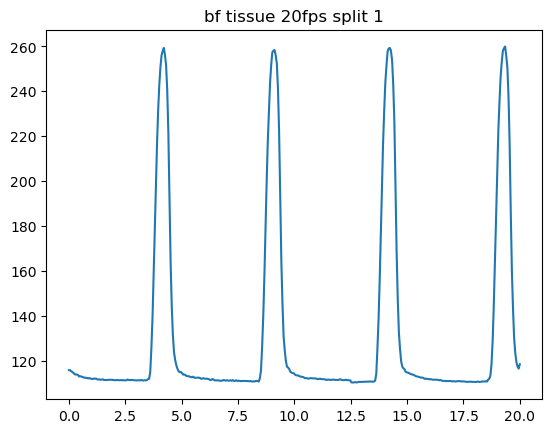

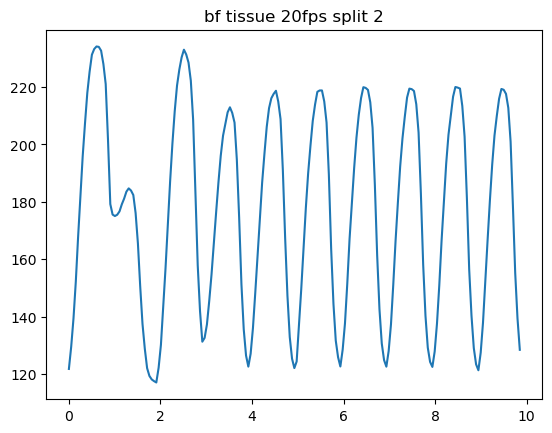

In [17]:
for split_i in range(len(splits)):
    for i, trace in df_f0_splits[split_i].iterrows():
        plt.plot(trace)
        plt.title(i)
        plt.show()